In [1]:
# Authors: A07 Section

In [19]:
!pip3 install fastfuels==0.5.3
!pip3 install s3fs==0.5.2 
!pip3 install fsspec==0.8.3 

In [2]:
import fastfuels
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import rasterio
import rasterio.mask
from shapely import geometry
import geopandas as gpd
from fiona import crs

In [4]:
from scipy import stats

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
#src=rasterio.open(r'LF2021_FBFM40_210_CONUS/LF2021_FBFM40_210_CONUS/Tif/LC21_F40_210.tif')
src=rasterio.open('LC21_F40_210.tif')

print(type(src))
print(src.block_shapes)
display(src.files)
print(src.is_tiled)

<class 'rasterio.io.DatasetReader'>
[(128, 128)]


['LC21_F40_210.tif']

True


In [10]:
#original numbers:
# minx, miny = -122.0003, 45
# maxx, maxy = -122, 45.0003

minx, miny = -121.806464, 38.126339
maxx, maxy = -121.806164, 38.126639

bbox = geometry.box(minx, miny, maxx, maxy)

geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=crs.from_epsg(4326))  #Word Geodetic System 1984

print(geo)

                                            geometry
0  POLYGON ((-121.80616 38.12634, -121.80616 38.1...


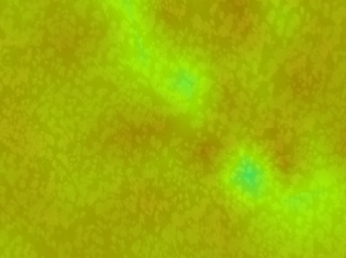
<div align="center">(Forest area with fastfuels sav layered over)<div>

                                            geometry
0  POLYGON ((-2213370.933 1979364.929, -2213361.9...


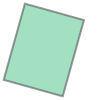

In [11]:
geo_utm=geo.to_crs(crs=src.crs.data)
print(geo_utm)
display(geo_utm.loc[0,"geometry"])

In [12]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]
coords=getFeatures(geo_utm)
display(coords)

[{'type': 'Polygon',
  'coordinates': [[[-2213370.9326172518, 1979364.9285774315],
    [-2213361.9134944724, 1979397.321777114],
    [-2213387.008522878, 1979404.3089388362],
    [-2213396.0277479156, 1979371.9157676257],
    [-2213370.9326172518, 1979364.9285774315]]]}]

In [13]:
out_img, out_transform = rasterio.mask.mask(src, shapes=coords, crop=True)

In [14]:
print(np.unique(out_img))

[  102 32767]


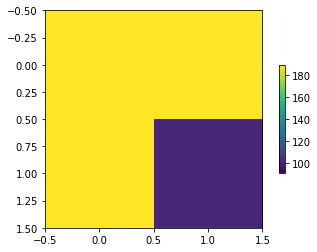

In [15]:
fig,ax=plt.subplots()

h=ax.imshow(out_img[0,:,:], origin="upper", vmin=91., vmax=189.)
fig.colorbar(h, shrink=0.5)

Mapped data values align with the fastfuels classification of TL5, High load conifer litter, light slash or dead fuel, spread rate and flame low.

In [20]:
fio = fastfuels.open('https://wifire-data.sdsc.edu:9000/fastfuels/index.fio', ftype='s3', username='fastfuels', password='Treatment##Buffet')
fio.cache_limit = 1e14

PermissionError: Forbidden

In [ ]:
roi = fio.query(-122.0003, 45, 15)
roi.view('sav')

In [16]:
print(roi.get_properties())

['bulk_density', 'sav', 'moisture', 'fuel_depth', 'elevation']


In [17]:
# roi = fio.query(minx, miny, 30)
# roi.view('bulk_density')

In [18]:
raw_sav_data = roi.data_dict['sav']
raw_moisture_data = roi.data_dict['moisture']
raw_elevation_data = roi.data_dict['elevation']
raw_bd_data = roi.data_dict['bulk_density']

In [19]:
raw_moisture_data

array([[[0.2, 0. , 0. , ..., 0. , 0. , 0. ],
        [0.2, 0. , 0. , ..., 0. , 0. , 0. ],
        [0.2, 0. , 0. , ..., 0. , 0. , 0. ],
        ...,
        [0.2, 0. , 0. , ..., 0. , 0. , 0. ],
        [0.2, 0. , 0. , ..., 0. , 0. , 0. ],
        [0.2, 0. , 0. , ..., 0. , 0. , 0. ]],

       [[0.2, 0. , 0. , ..., 0. , 0. , 0. ],
        [0.2, 0. , 0. , ..., 0. , 0. , 0. ],
        [0.2, 0. , 0. , ..., 0. , 0. , 0. ],
        ...,
        [0.2, 0. , 0. , ..., 0. , 0. , 0. ],
        [0.2, 0. , 0. , ..., 0. , 0. , 0. ],
        [0.2, 0. , 0. , ..., 0. , 0. , 0. ]],

       [[0.2, 0. , 0. , ..., 0. , 0. , 0. ],
        [0.2, 0. , 0. , ..., 0. , 0. , 0. ],
        [0.2, 0. , 0. , ..., 0. , 0. , 0. ],
        ...,
        [0.2, 0. , 0. , ..., 0. , 0. , 0. ],
        [0.2, 0. , 0. , ..., 0. , 0. , 0. ],
        [0.2, 0. , 0. , ..., 0. , 0. , 0. ]],

       ...,

       [[0.2, 0. , 0. , ..., 0. , 0. , 0. ],
        [0.2, 0. , 0. , ..., 0. , 0. , 0. ],
        [0.2, 0. , 0. , ..., 0. , 0. , 0. 

In [20]:
raw_sav_data.shape

(30, 30, 128)

In [21]:
pixels = []
for x in range(len(raw_sav_data)):
    for y in raw_sav_data[x]:
        avg = y.mean()
        pixels.append(avg)

In [22]:
import pandas as pd
df = pd.DataFrame()
df['Pix'] = pixels

<AxesSubplot:>

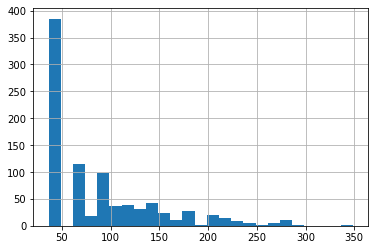

In [23]:
df['Pix'].hist(bins=25)

In [24]:
df[df['Pix']<50].shape[0]/df.shape[0]

0.42777777777777776

In [25]:
#helper function from above
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [76]:
def deez_nuts(long, lat):
    
    output = []

    minx, miny = lat, long
    maxx, maxy = lat + 0.0003, long + 0.0003

    bbox = geometry.box(minx, miny, maxx, maxy)

    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=crs.from_epsg(4326))  #Word Geodetic System 1984
    geo_utm=geo.to_crs(crs=src.crs.data)
    coords=getFeatures(geo_utm)
    out_img, out_transform = rasterio.mask.mask(src, shapes=coords, crop=True)
    
    output.append(np.unique(out_img)[0])
    fig,ax=plt.subplots(1,2)

    h=ax[0].imshow(out_img[0,:,:], origin="upper", vmin=91., vmax=189.)
    fig.colorbar(h, shrink=0.5)
    
    roi = fio.query(lat, long, 15)
    print(roi.view('sav'))
    raw_sav_data = roi.data_dict['sav']
    
    pixels = []
    
#     for x in range(len(raw_sav_data)):
#         heights = 0
#         for y in range(len(raw_sav_data)):
#             sum_of_heights = heights + sum(raw_sav_data[x][y])
#             pixels.append(sum_of_heights)

    for x in range(len(raw_sav_data)):
        for y in raw_sav_data[x]:
            sum_of_heights = y.sum()
            pixels.append(sum_of_heights)
            
    df = pd.DataFrame()
    df['Pix'] = pixels
    print(df['Pix'].hist())
    
    output.append([sum(pixels)/len(pixels)])#(df[df['Pix'] < 20].shape[0] / df.shape[0] * 100)
    
    print('The label for this region is ' + str(output[0]))
    print('The sum of non-flat surface in this region is ' + str(output[1]))
    return pixels#raw_sav_data

Bounding box query found in single source: ca_set/ca_74.fio


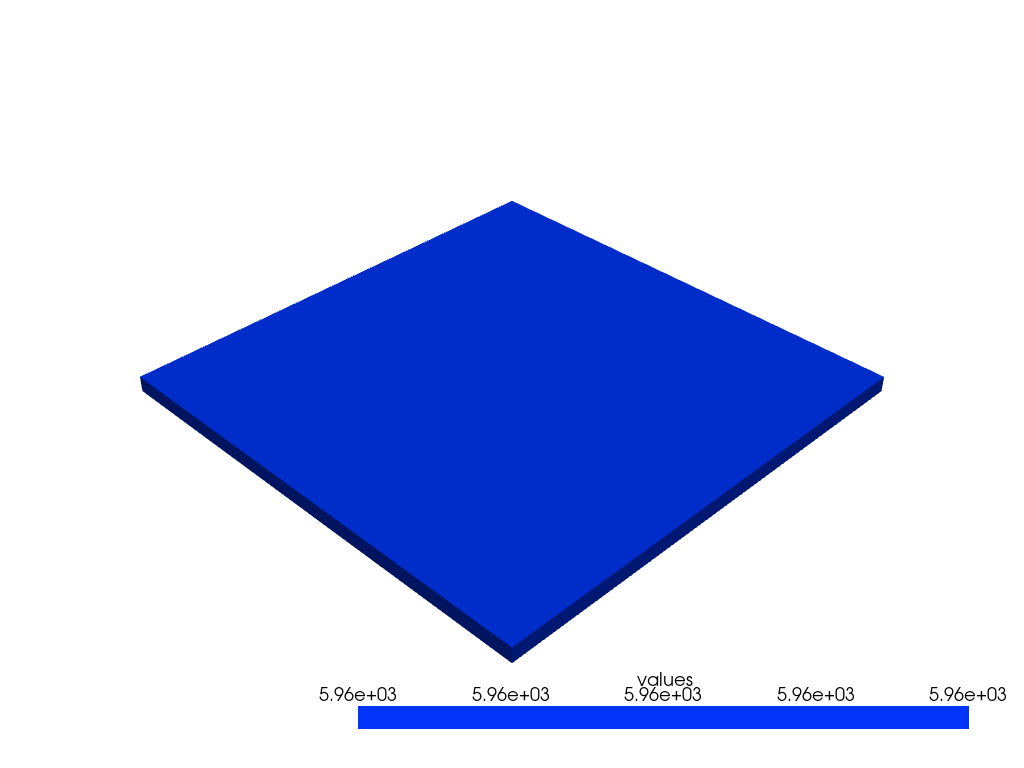

None
AxesSubplot(0.547727,0.125;0.281818x0.755)
The label for this region is 102
The sum of non-flat surface in this region is [5833.78466796875]


[5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 5833.7847,
 583

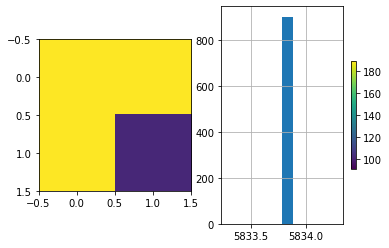

In [77]:
deez_nuts(38.126339, -121.806464) #grass

Bounding box query found in single source: ca_set/ca_238.fio
AxesSubplot(0.125,0.125;0.775x0.755)
The label for this region is 102
The sum of non-flat surface in this region is [5960.78466796875]


[102, [5960.78466796875]]

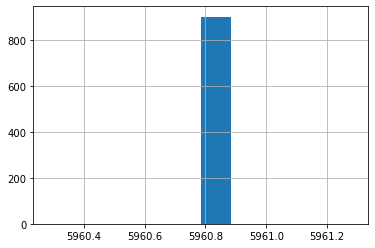

In [28]:
deez_nuts(32.938576, -116.684257) #grass

Bounding box query found in single source: ca_set/ca_237.fio
AxesSubplot(0.125,0.125;0.775x0.755)


array([5992.157,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.

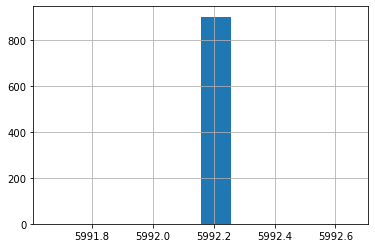

In [60]:
deez_nuts(32.885801, -116.873526) #grass shrub

Bounding box query found in single source: ca_set/ca_237.fio


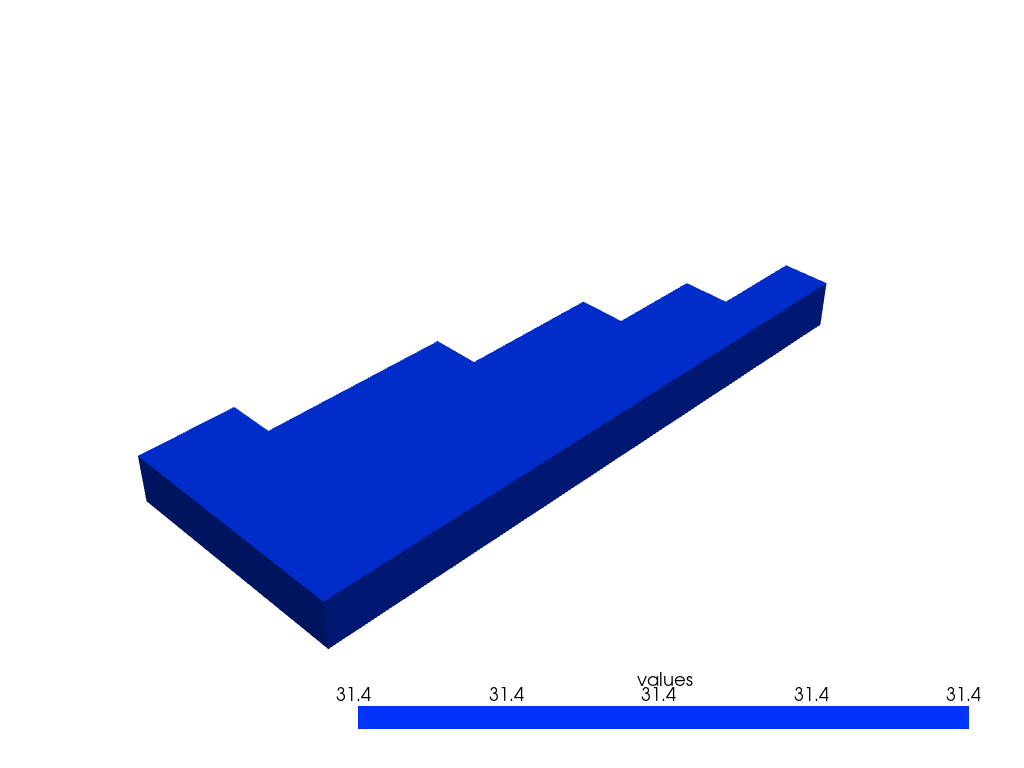

None
AxesSubplot(0.547727,0.125;0.281818x0.755)
The label for this region is 91
The sum of non-flat surface in this region is [-126.52525045606825]


[-128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 

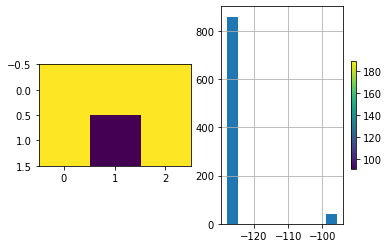

In [78]:
deez_nuts(32.783077, -116.953164) #urban

In [83]:
#deez_nuts( 39.151537, -120.010631 ) #Lake Tahoe

Bounding box query found in single source: ca_set/ca_81.fio


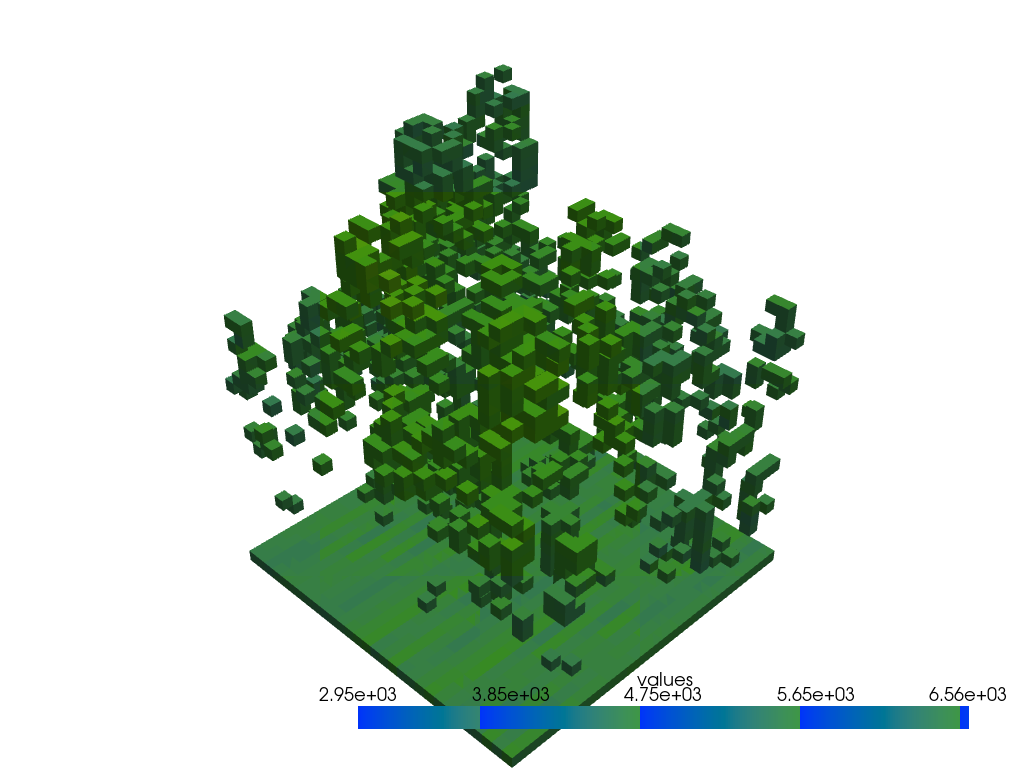

None
AxesSubplot(0.547727,0.125;0.281818x0.755)
The label for this region is 186
The sum of non-flat surface in this region is [9748.565665418837]


[25228.02,
 32382.96,
 18073.078,
 3763.196,
 3763.196,
 3763.196,
 3794.5686,
 3794.5686,
 3794.5686,
 14370.118,
 3825.9412,
 10667.156,
 10667.156,
 3857.3137,
 3857.3137,
 7434.784,
 7434.784,
 7466.157,
 11043.628,
 7466.157,
 3888.6865,
 3920.059,
 14181.883,
 10761.275,
 21054.473,
 3951.4316,
 18261.314,
 11106.373,
 18292.688,
 11137.746,
 28774.117,
 18073.078,
 21650.549,
 3763.196,
 3763.196,
 3763.196,
 3763.196,
 3763.196,
 3794.5686,
 3794.5686,
 7215.177,
 10667.157,
 7246.549,
 7403.412,
 3857.3137,
 14589.726,
 18010.334,
 14621.099,
 10886.766,
 7466.157,
 3920.059,
 3920.059,
 3920.059,
 17790.727,
 3951.4316,
 3951.4316,
 3951.4316,
 14715.217,
 14715.217,
 13460.314,
 14464.235,
 10886.765,
 14464.235,
 3731.8235,
 7152.4316,
 3731.8235,
 7183.8037,
 3763.196,
 3763.196,
 3794.5686,
 3794.5686,
 10949.51,
 10980.883,
 10980.883,
 3857.3137,
 18167.195,
 25322.137,
 11043.628,
 18198.57,
 3888.6865,
 11075.0,
 11075.0,
 7497.53,
 11106.373,
 7528.9023,
 3982.8042,


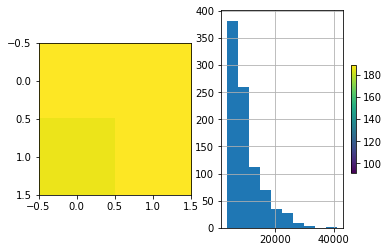

In [84]:
deez_nuts( 38.989042, -120.579882 ) #forest in Lake Tahoe

Bounding box query found in single source: ca_set/ca_183.fio


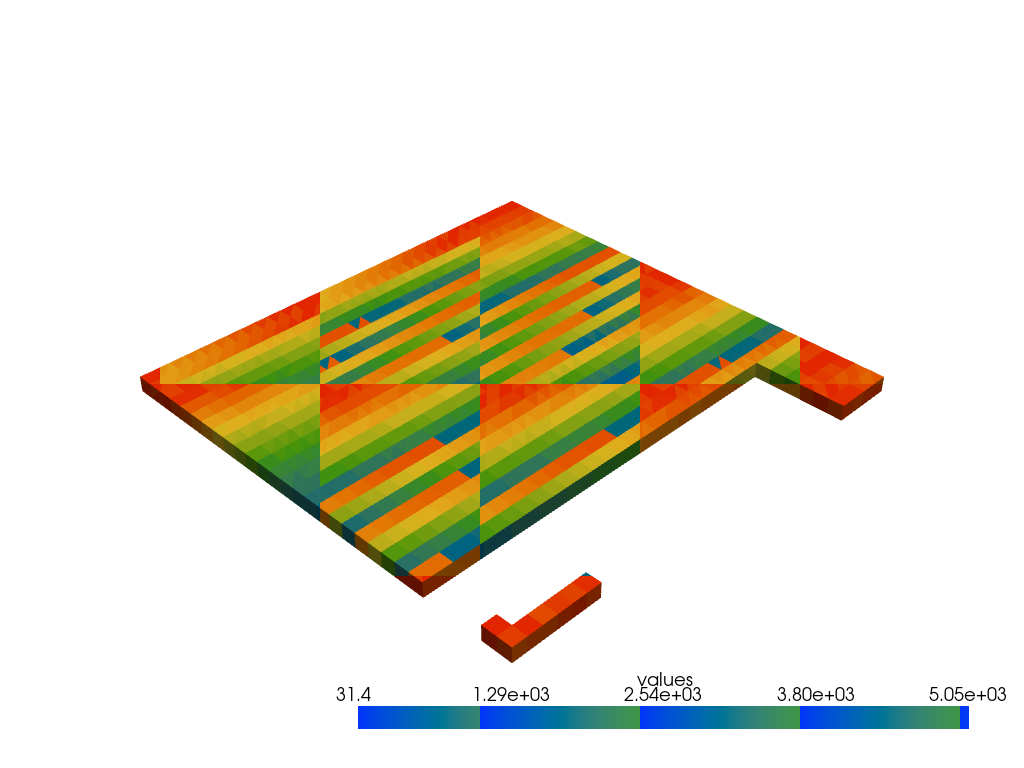

None
AxesSubplot(0.547727,0.125;0.281818x0.755)
The label for this region is 99
The sum of non-flat surface in this region is [1176.712478942871]


[4923.9805,
 4735.745,
 4547.51,
 4359.275,
 4171.0396,
 3982.8042,
 3794.5686,
 3606.3333,
 3418.0981,
 3229.8628,
 3041.6274,
 2853.3923,
 2665.157,
 2476.9216,
 2320.0588,
 2131.8237,
 1943.5884,
 1755.3529,
 1567.1177,
 1378.8823,
 1190.6471,
 1002.41187,
 814.17645,
 625.94116,
 531.82355,
 500.451,
 469.07843,
 469.07843,
 437.70593,
 406.33337,
 4892.608,
 4704.3726,
 4516.1377,
 4327.9023,
 4139.667,
 3920.059,
 3731.8235,
 3543.5881,
 3355.353,
 3167.1177,
 2947.5098,
 2759.2747,
 2571.0393,
 2382.804,
 2194.5688,
 2006.3335,
 1786.7255,
 1598.4902,
 1410.2549,
 1222.0197,
 1033.7844,
 814.17645,
 625.94116,
 437.70593,
 343.58823,
 312.2157,
 312.2157,
 280.84314,
 280.84314,
 249.47058,
 4892.608,
 4673.0,
 4484.765,
 4296.53,
 4076.9219,
 3888.6865,
 3669.0784,
 3480.8433,
 3261.2354,
 3073.0,
 2884.7646,
 2665.157,
 2476.9216,
 2257.3137,
 2069.0786,
 1880.8433,
 1661.2354,
 1473.0,
 1253.3922,
 1065.1569,
 845.549,
 657.3137,
 469.07843,
 249.47058,
 155.35297,
 155.35297

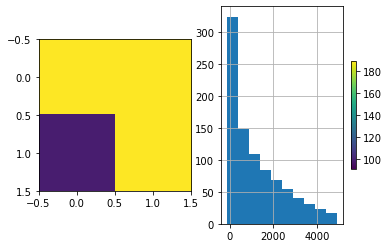

In [85]:
deez_nuts( 34.860323, -117.718669 ) #some desert place in California

Bounding box query found in single source: ca_set/ca_189.fio


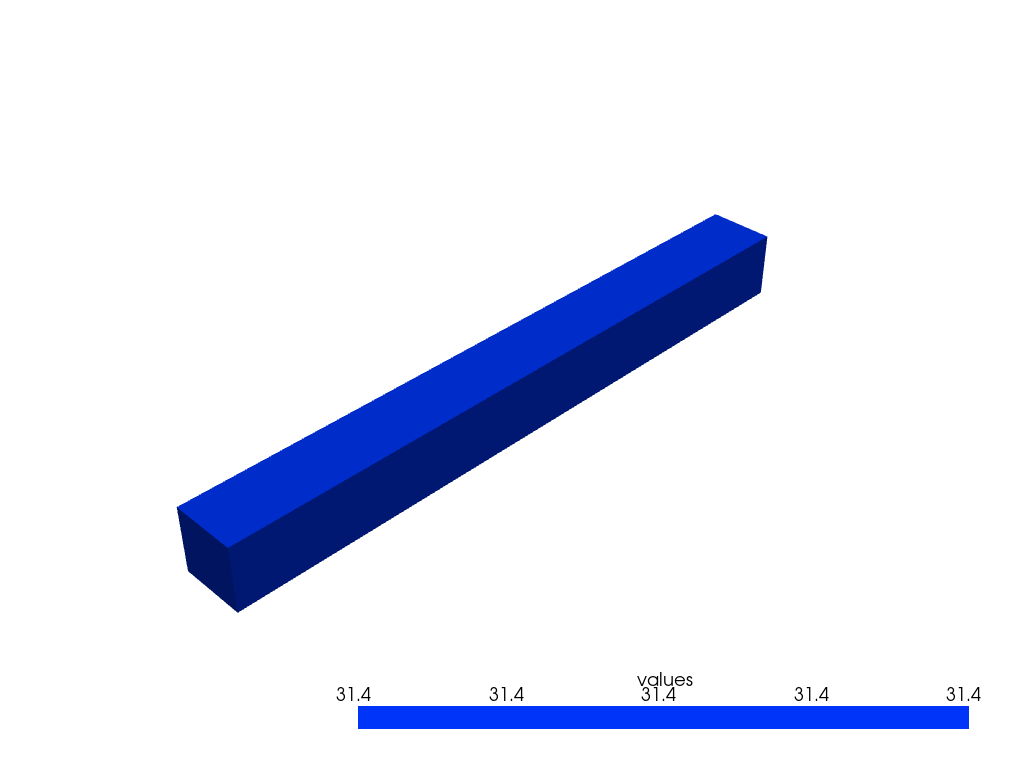

None
AxesSubplot(0.547727,0.125;0.281818x0.755)
The label for this region is 99
The sum of non-flat surface in this region is [-127.64030498928494]


[-128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -95.62745,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -95.62745,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -95.62745,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 -128.0,
 

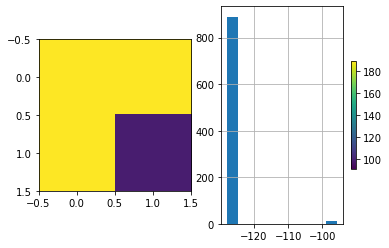

In [86]:
deez_nuts( 35.417153, -116.658997 ) #another desert place

Bounding box query found in single source: co_set/co_166.fio


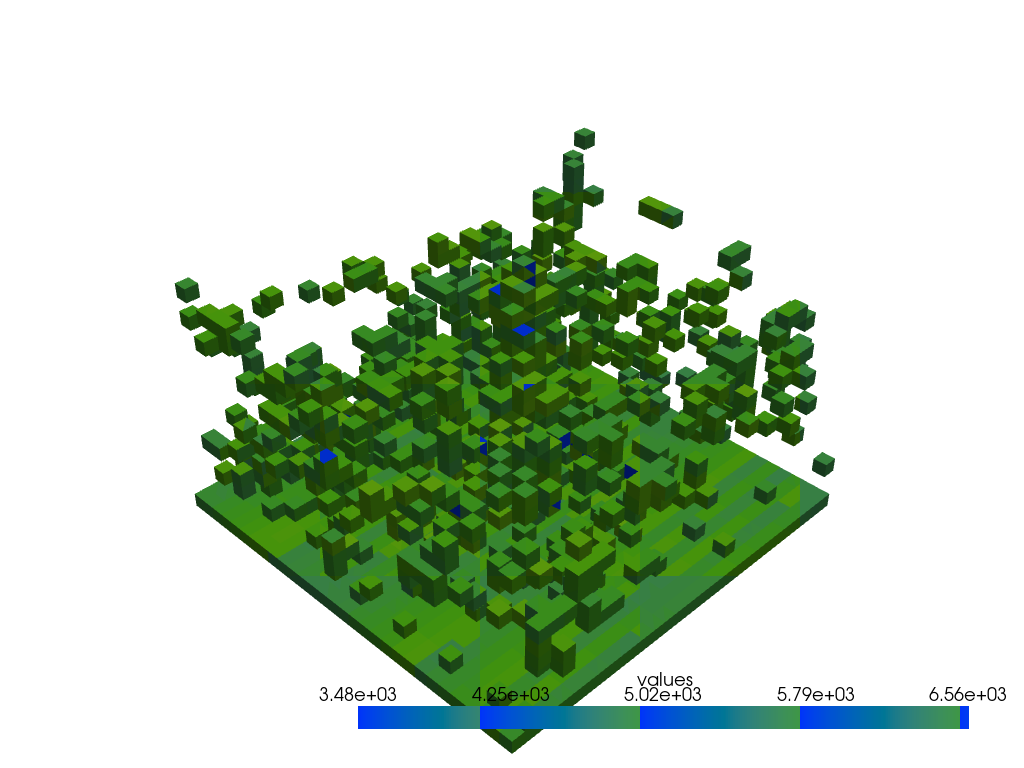

None
AxesSubplot(0.547727,0.125;0.281818x0.755)
The label for this region is 165
The sum of non-flat surface in this region is [7710.0089946831595]


[4108.2944,
 7685.765,
 4108.2944,
 17224.02,
 4139.667,
 4139.667,
 21650.55,
 7654.3926,
 14621.098,
 7748.5103,
 7654.3926,
 4171.0396,
 4171.0396,
 11325.98,
 11325.98,
 14903.451,
 7748.5103,
 4171.0396,
 7654.3926,
 7779.883,
 4202.412,
 4202.412,
 7779.883,
 4202.412,
 11357.354,
 7779.883,
 14934.824,
 7685.765,
 4202.412,
 7779.883,
 4108.2944,
 4108.2944,
 4139.667,
 4139.667,
 4139.667,
 4139.667,
 4171.0396,
 21587.805,
 4171.0396,
 4171.0396,
 7748.5103,
 11231.863,
 4171.0396,
 7779.883,
 11357.354,
 4202.412,
 4202.412,
 4202.412,
 7685.765,
 4202.412,
 11357.354,
 7779.883,
 4202.412,
 4202.412,
 4202.412,
 14934.824,
 7779.883,
 7685.765,
 4202.412,
 4202.412,
 4108.2944,
 4139.667,
 10697.529,
 17255.393,
 10697.529,
 4171.0396,
 7654.3926,
 4171.0396,
 10760.275,
 4202.412,
 7779.883,
 4202.412,
 4202.412,
 11263.236,
 7779.883,
 11357.354,
 4202.412,
 11357.354,
 4202.412,
 11357.354,
 4202.412,
 4202.412,
 11357.354,
 4202.412,
 4233.7847,
 11388.727,
 14966.197,
 

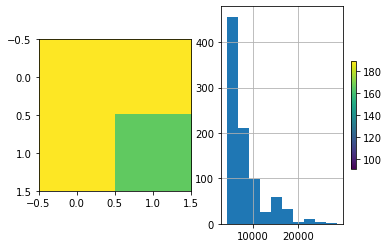

In [87]:
deez_nuts( 38.325022, -106.402827 ) #forest

Bounding box query found in single source: co_set/co_166.fio


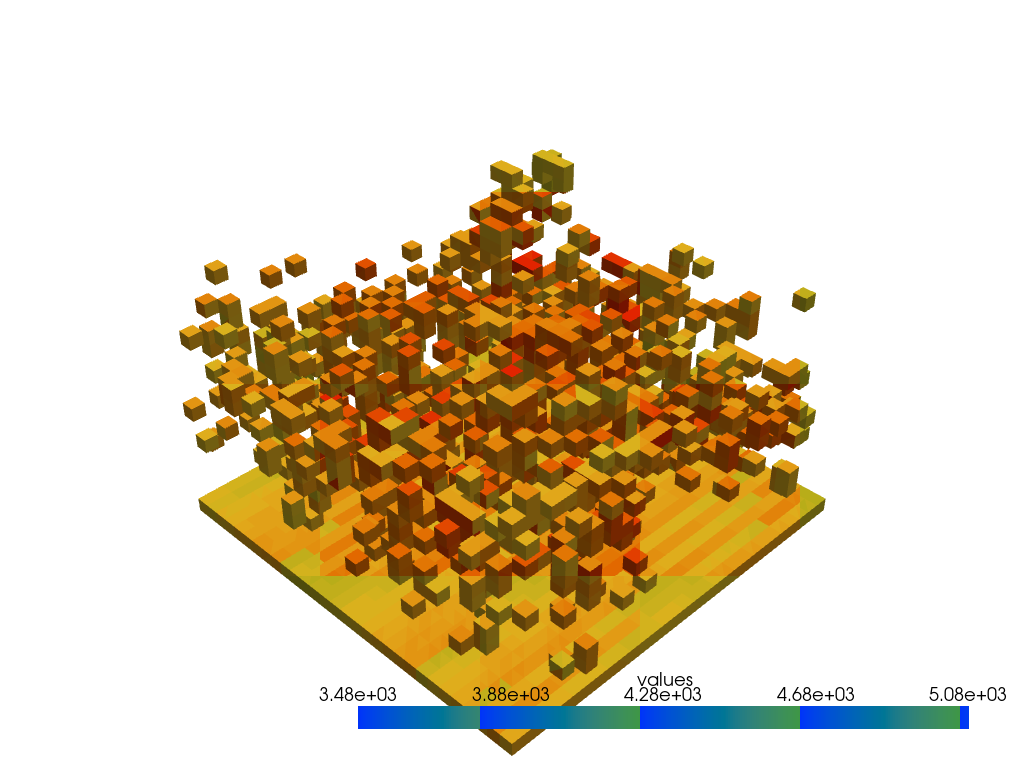

None
AxesSubplot(0.547727,0.125;0.281818x0.755)
The label for this region is 32767
The sum of non-flat surface in this region is [8596.646788194445]


[7811.2554,
 7748.5103,
 7842.628,
 11451.471,
 15028.941,
 7905.373,
 14903.451,
 7842.628,
 7968.118,
 4390.6475,
 14966.197,
 8030.8633,
 11608.334,
 4484.765,
 8062.236,
 7936.7456,
 15185.805,
 4453.3926,
 7999.4907,
 7905.373,
 4390.6475,
 7968.118,
 22089.766,
 4359.275,
 4359.275,
 7811.2554,
 11388.727,
 7811.2554,
 4296.53,
 4296.53,
 4233.7847,
 4265.157,
 7874.0005,
 7874.0005,
 7905.373,
 4359.275,
 11514.217,
 11451.471,
 7968.118,
 4422.02,
 4453.3926,
 8030.8633,
 7968.118,
 4484.765,
 4484.765,
 7968.118,
 7968.118,
 11608.334,
 4453.3926,
 7905.373,
 7999.4907,
 18512.295,
 11357.354,
 11420.099,
 4359.275,
 4359.275,
 11388.727,
 7905.373,
 4296.53,
 4296.53,
 4265.157,
 14997.569,
 4296.53,
 4327.9023,
 4327.9023,
 18669.158,
 7968.118,
 11545.589,
 4422.02,
 4422.02,
 8030.8633,
 8062.236,
 7968.118,
 7999.4907,
 4516.1377,
 18826.02,
 11639.707,
 11639.707,
 4453.3926,
 8030.8633,
 4422.02,
 4422.02,
 14934.824,
 7968.118,
 7936.7456,
 4359.275,
 4327.9023,
 4327.

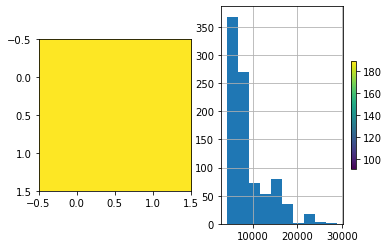

In [88]:
deez_nuts( 38.341057, -106.478022 ) #forest

Bounding box query found in single source: co_set/co_167.fio


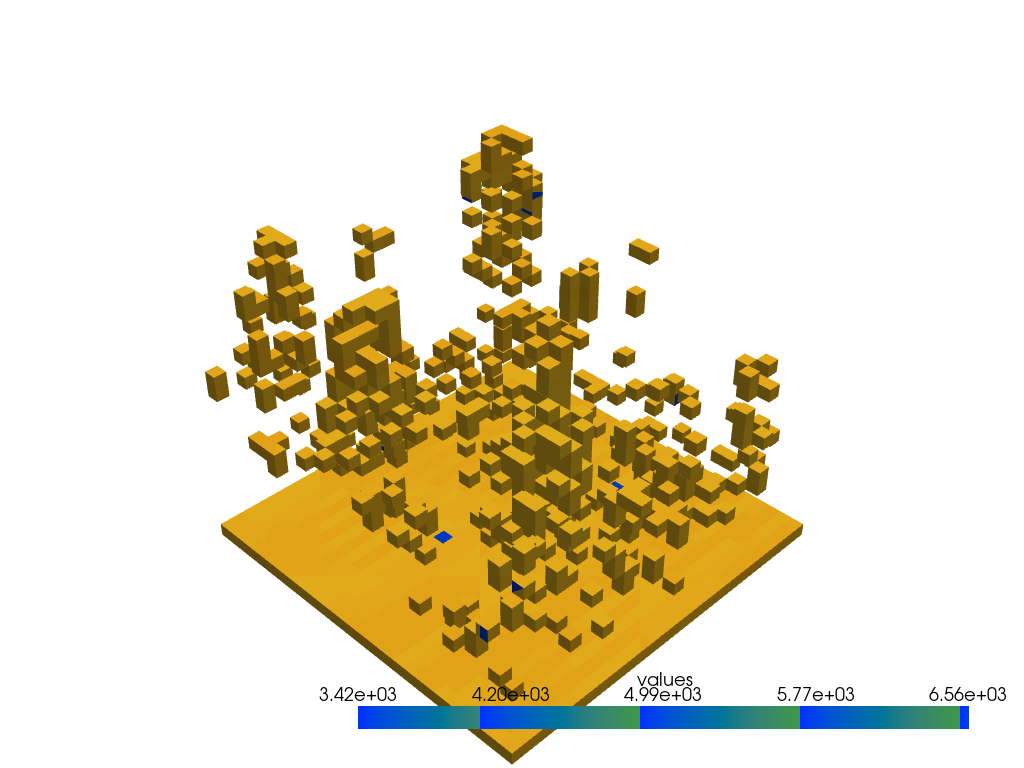

None
AxesSubplot(0.547727,0.125;0.281818x0.755)
The label for this region is 142
The sum of non-flat surface in this region is [7812.409632161458]


[5363.1963,
 5363.1963,
 5363.1963,
 5363.1963,
 5363.1963,
 9787.727,
 5331.8237,
 5331.8237,
 15373.039,
 9787.727,
 9787.727,
 5331.8237,
 9787.727,
 16064.236,
 8909.295,
 8815.177,
 9787.727,
 8752.432,
 5331.8237,
 5331.8237,
 5331.8237,
 5331.8237,
 9787.727,
 8752.432,
 8752.432,
 5331.8237,
 8752.432,
 5331.8237,
 5331.8237,
 5331.8237,
 5363.1963,
 5363.1963,
 5363.1963,
 5363.1963,
 5363.1963,
 8846.549,
 5363.1963,
 5363.1963,
 5363.1963,
 5331.8237,
 9787.727,
 5331.8237,
 5331.8237,
 5331.8237,
 5331.8237,
 5331.8237,
 5331.8237,
 5331.8237,
 12173.039,
 8752.432,
 5331.8237,
 5331.8237,
 5331.8237,
 5331.8237,
 5331.8237,
 8752.432,
 5331.8237,
 5331.8237,
 5331.8237,
 5331.8237,
 5363.1963,
 5363.1963,
 5363.1963,
 8846.549,
 5363.1963,
 5363.1963,
 12204.412,
 5363.1963,
 5363.1963,
 5363.1963,
 12518.138,
 5331.8237,
 5331.8237,
 5331.8237,
 8815.177,
 5331.8237,
 5331.8237,
 8752.432,
 5331.8237,
 5331.8237,
 5331.8237,
 5331.8237,
 5331.8237,
 5331.8237,
 5331.8237,

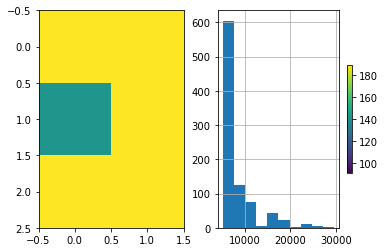

In [89]:
deez_nuts( 38.295717, -105.804288 ) #forest

Rough Summary

0 = Water

~1 = Urban

~1-1k = Desert (Depends on the amount of dry plants in a desert)

~6k = Grass/Shrub

~7k-10k = Forest

Rough Summary 1/11/2022: if the histogram is not a bimodal distribution, then the data could be used to determine its geographical features.

Observation: most of the forests have a right skew distribution for their sav height values.